# Setup

In [3]:
# !pip install statsmodels
# !pip install pmdarima
# !pip install matplotlib
# !pip install seaborn
# # !pip install "black[jupyter]"
# !pip3 install statsforecast
# # !pip install prophet
# !pip install --upgrade plotly
# !pip install learntools


In [1]:
# basic
import sys
from datetime import date
import pandas as pd
import numpy as np
from numpy import inf
import time 
from datetime import datetime

# plotting
from matplotlib import pyplot, dates
import seaborn as sns
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Smoothing & Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# ARIMA
import statsmodels.api as sm
from statsmodels.tsa.stattools import acovf, acf, pacf, pacf_yw, pacf_ols
from statsmodels.tsa.ar_model import AR, ARResults, AutoReg, ar_select_order
from statsmodels.tsa.arima_model import ARMA, ARMAResults, ARIMAResults
from statsmodels.tsa.arima.model import  ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

# prophet
import prophet

# forecast
from statsforecast import StatsForecast

# eval
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import mse, rmse, meanabs

# descriptive tests
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller,grangercausalitytests
from statsmodels.graphics.tsaplots import month_plot, quarter_plot, plot_acf, plot_pacf


# warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

/Users/axiao/.pyenv/versions/3.8.18/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%cd /Users/axiao/Desktop/Projects/projects/store_sales/data

holidays_events = pd.read_csv('holidays_events.csv', index_col='date', parse_dates=True)
transactions = pd.read_csv('transactions.csv',index_col='date', parse_dates=True)
oil =  pd.read_csv('oil.csv',index_col='date', parse_dates=True)
stores = pd.read_csv('stores.csv')

# train = pd.read_csv('train.csv', index_col='date', parse_dates=True)
train_engineered = pd.read_csv('train_engineered.csv', index_col='date', parse_dates=True)  # for re-run purposes
test = pd.read_csv('test.csv', index_col='date', parse_dates=True)

/Users/axiao/Desktop/Projects/projects/store_sales/data


# A little More Data Engineering

let's first see which `family`-`store_nbr` combination is the best selling one

In [4]:
tmp = train_engineered.reset_index()
tmp = tmp[['sales','family','store_nbr']].groupby(['family', 'store_nbr']).sum().reset_index()
tmp = tmp.sort_values(by='sales', ascending=False)

fam_lst = tmp[:2]['family'].tolist()
fam_lst.extend(tmp[-2:]['family'].tolist())
store_lst = tmp[:2]['store_nbr'].astype(str).tolist()
store_lst.extend(tmp[-2:]['store_nbr'].astype(str).tolist())


In [4]:
tmp.head(3)

,family,store_nbr,sales
691,GROCERY I,44,1.638606e+07
692,GROCERY I,45,1.634975e+07
694,GROCERY I,47,1.551453e+07


add a `uid` column (with product family and store number info combined) to `train_engineered`

In [5]:

# create a list for the top 10 store num + family combo
i = 0
lst = []
while i < 4:
    uid = fam_lst[i] + '_' + store_lst[i]
    lst.append(uid)
    i += 1

train_engineered = train_engineered.reset_index()
train_engineered['uid'] = train_engineered['family'].astype(str)+'_'+train_engineered['store_nbr'].astype(str)


create a `tmp` dataframe to subset the best selling `family-store_nbr` combo (GROCERY I - Store 44)

In [6]:
features_to_use = [
    'date','sales','onpromotion','oil_price', 'out_of_region',
    'is_year_start','is_year_end',  
    'day_of_year',
    'is_wknd','wageday', 'uid'
]


tmp = train_engineered[train_engineered['uid']=='GROCERY I_44']

tmp = tmp[features_to_use]
tmp = tmp.set_index('date')

# set index freq
tmp = tmp.asfreq('d')

we notice that there're NA's in the dataframe - Christmas sales are always 0

In [7]:
tmp[tmp.isna().any(axis=1)]

,sales,onpromotion,oil_price,out_of_region,is_year_start,is_year_end,day_of_year,is_wknd,wageday,uid
date,,,,,,,,,,
2013-12-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-12-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Interpolate missing `oil_price`; fill `uid` as `GROCERY I_44`. Then fill the remaining columns as 0.

In [8]:
tmp[['oil_price']]= tmp[['oil_price']].interpolate(method='linear')
tmp['uid'] = 'GROCERY I_44'
# tmp[tmp.isna()] = 0 
tmp = tmp.fillna(0)


# tmp = df
tmp = tmp.asfreq('D')

# extrapolate NAs

# exclude a col
# tmp = tmp.drop(columns=['if_holiday'], axis=1)

tmp.index

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
               '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
               '2017-08-14', '2017-08-15'],
              dtype='datetime64[ns]', name='date', length=1688, freq='D')

# EMWA

Simple `EMWA` model, using a `span` of `7` (assuming weekly seasonality). 

In [9]:
# use a span of 12 months
span = 7           # n-period EW moving average
alpha = 2/(span+1)

tmp_ewma = tmp.copy()
tmp_ewma['EWMA7'] = tmp_ewma['sales'].ewm(alpha=alpha, adjust=False).mean()


- EWMA provides an improvement over MA but still isn’t the best forecasting algorithm. 
- EWMA and SES (Simple Exponential Smoothing) are synonyms, and the entire exponential smoothing family of algorithms is decent for forecasting. 
- You’ll need more than a single smoothing parameter (alpha) to capture both trend and seasonality ([reference](https://towardsdatascience.com/time-series-from-scratch-exponentially-weighted-moving-averages-ewma-theory-and-implementation-607661d574fe)).

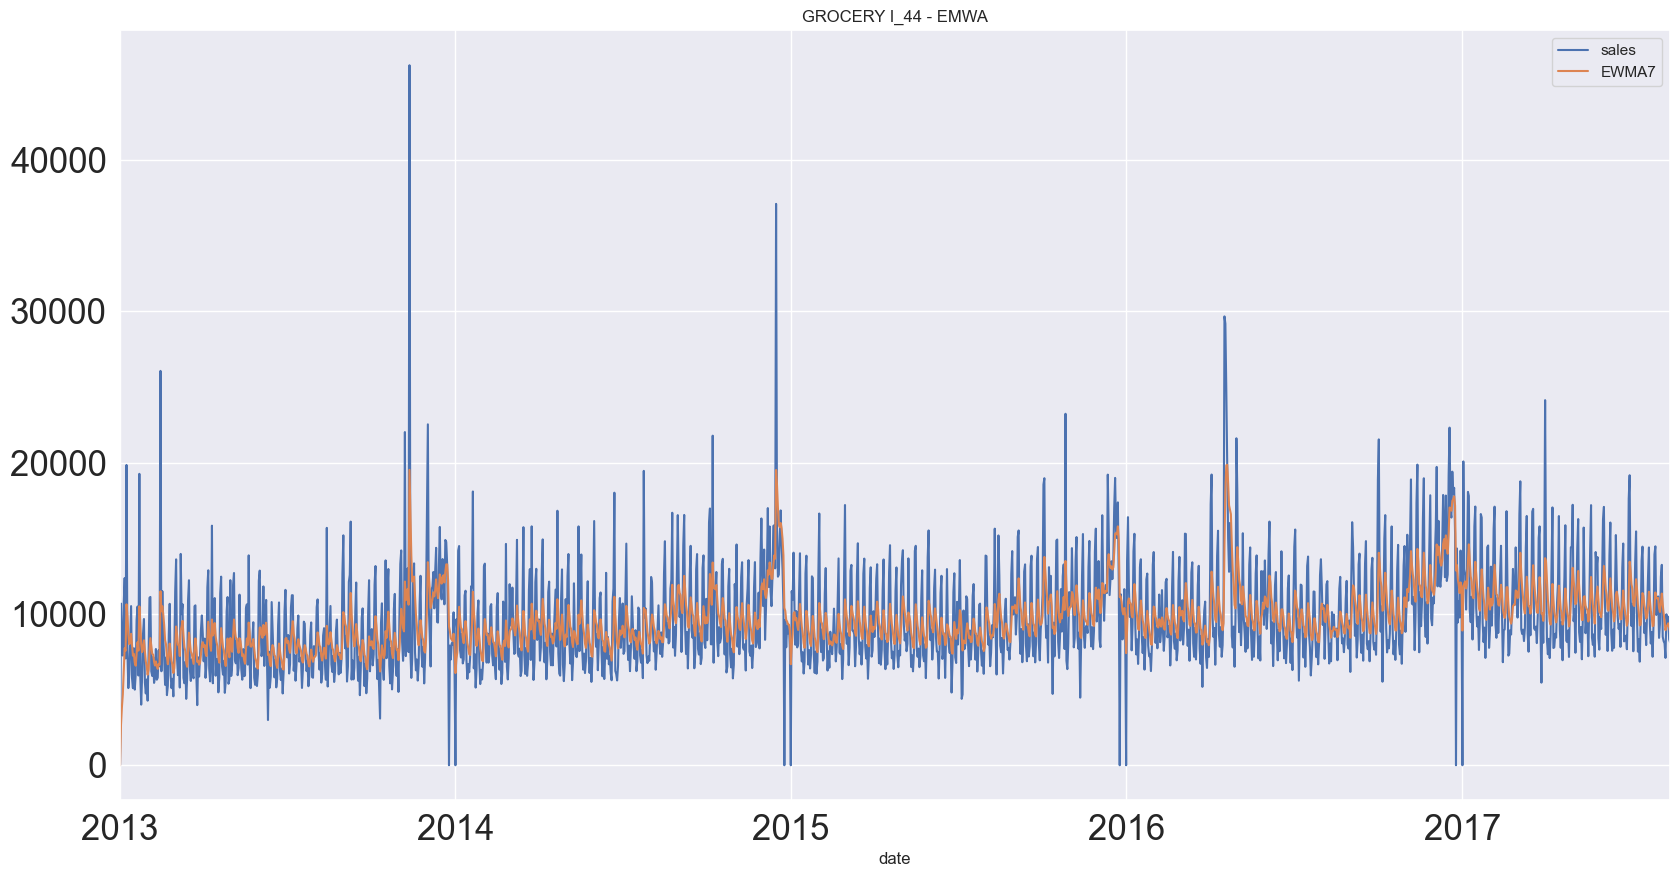

In [10]:
sns.set_theme()
sns.set(rc={'figure.figsize':[20,10]})

tmp_ewma[['sales','EWMA7']].plot(title='GROCERY I_44 - EMWA', fontsize=25);

# ARIMA

## `auto_arima`

In [11]:

train = tmp.iloc[:round(len(tmp) * .8)+1]
test = tmp.iloc[round(len(tmp) * .8)+1:]

model = auto_arima(train['sales'], seasonal=True, trace=False)
params = model.get_params()
order_aa = params.get('order')
seasonal_order_aa = params.get('seasonal_order')

p,d,q = order_aa[0], order_aa[1], order_aa[2] 
print(f'p: {p}')
print(f'd: {d}')
print(f'q: {q}')

p: 2
d: 1
q: 1


In [12]:
# fit model
model = ARIMA(train['sales'], order=(p,d,q))
results = model.fit()

# predict
start = len(train)
end = len(train) + len(test) - 1
preds = results.predict(start, end, type='levels').rename(f'ARIMA({p,d,q}) Preds') # type='levels' showing original data (as opposed to the differenced TS)


# concat result df
test2 = test.reset_index()

p_df = pd.DataFrame()
p_df = pd.concat(
    [
        preds.reset_index(drop=True, name='pred'), 
        test2[['date','uid', 'sales']]
    ], 
    axis=1)

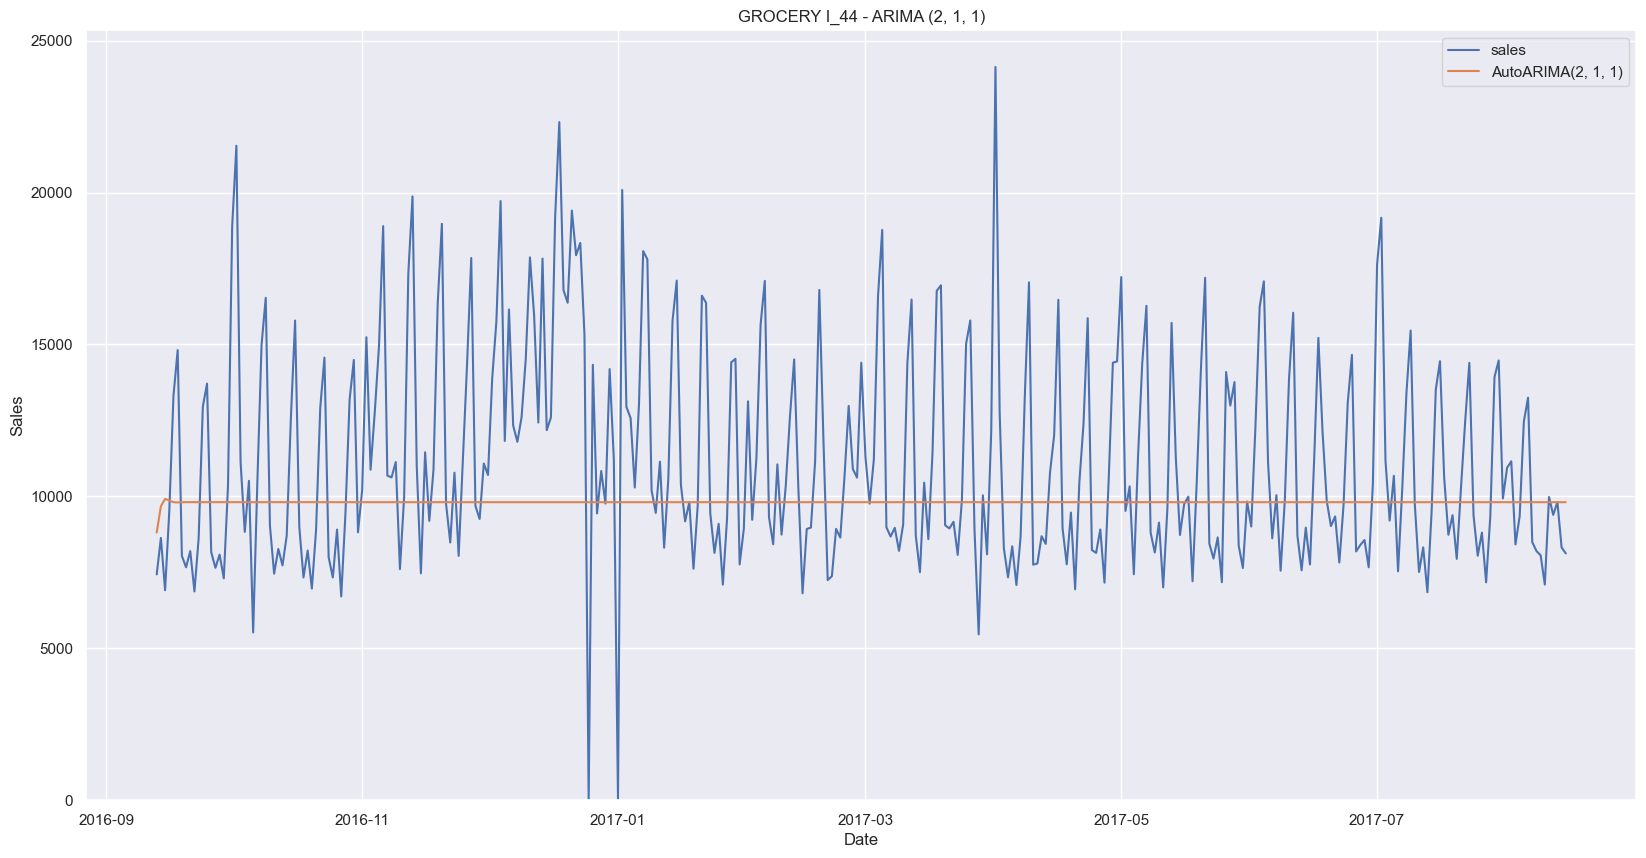

In [15]:
fig,ax = pyplot.subplots(1,1, figsize=(20,10))


ax.plot(p_df['date'], p_df['sales'], label='sales')
ax.plot(p_df['date'], p_df[f'ARIMA({p,d,q}) Preds'], label=f'AutoARIMA{p,d,q}')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
# ax.set_yscale('log')
ax.set_ylim(bottom=0)
ax.set_title(f'GROCERY I_44 - ARIMA {p,d,q}')
ax.legend();

In [14]:
error=rmse(p_df[f'ARIMA({p,d,q}) Preds'], p_df['sales'])
error

3851.5839430074802

## Manual Reading

we read in the third notebook `understanding_ts` that the p,d,q read 0,1,1. 

let's try them out

In [16]:
# fit model
model = ARIMA(train['sales'], order=(0,1,1))
results = model.fit()
# results.summary

# predict
start = len(train)
end = len(train) + len(test) - 1
preds = results.predict(start, end, type='levels').rename(f'ARIMA({p,d,q}) Preds') # type='levels' showing original data (as opposed to the differenced TS)


# concat result df
test2 = test.reset_index()
# test2['id'] = test2['family'].astype(str) + '_' + test2['store_nbr'].astype(str)

p_df = pd.DataFrame()
p_df = pd.concat(
    [
        preds.reset_index(drop=True, name='pred'), 
        test2[['date','uid', 'sales']]
    ], 
    axis=1)

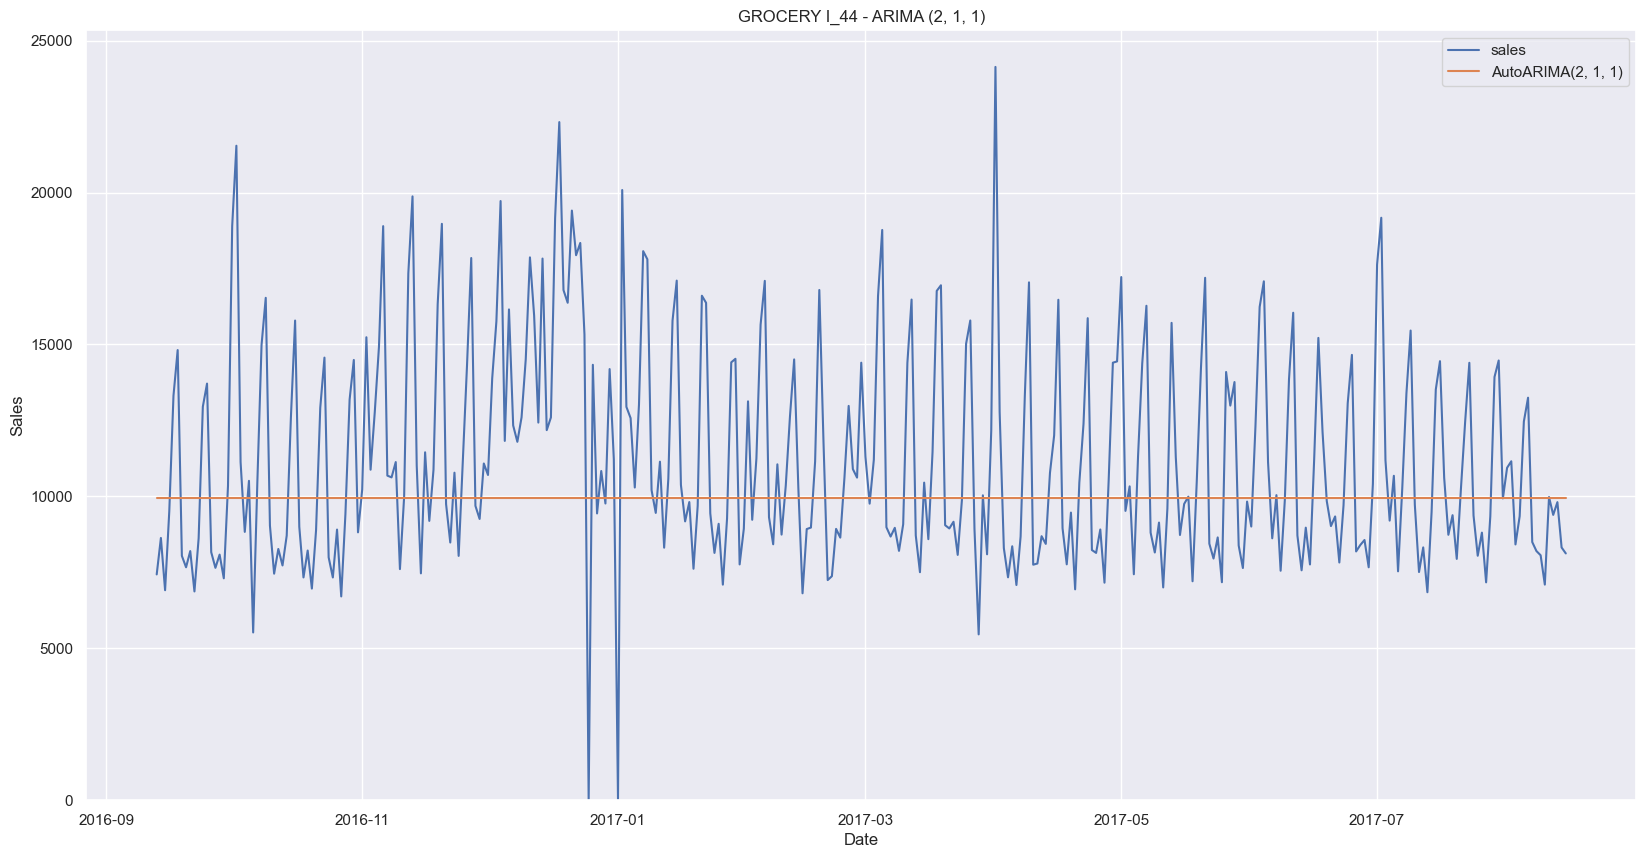

In [17]:
fig,ax = pyplot.subplots(1,1, figsize=(20,10))


ax.plot(p_df['date'], p_df['sales'], label='sales')
ax.plot(p_df['date'], p_df[f'ARIMA({p,d,q}) Preds'], label=f'AutoARIMA{p,d,q}')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
# ax.set_yscale('log')
ax.set_ylim(bottom=0)
ax.set_title(f'GROCERY I_44 - ARIMA {p,d,q}')
ax.legend();

In [18]:
error=rmse(p_df[f'ARIMA({p,d,q}) Preds'], p_df['sales'])
error

3801.3903564610714

a little better - but obviously we haven't done anything about the seasonal patterns yet

# SARIMA

## `auto_arima`

In [19]:
# split
train = tmp.iloc[:round(len(tmp) * .8)+1]
test = tmp.iloc[round(len(tmp) * .8)+1:]

# train w auto_arima
model = auto_arima(
    train['sales'], seasonal=True, trace=True, 
    #    start_p=3, max_p=10, 
    m=7
)

# get parameters
params = model.get_params()
order_aa = params.get('order')

p,d,q = order_aa[0], order_aa[1], order_aa[2] 
seasonal_order_aa = params.get('seasonal_order')
P,D,Q,C = seasonal_order_aa[0], seasonal_order_aa[1], seasonal_order_aa[2], seasonal_order_aa[3]


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=3.09 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=26272.630, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=25933.243, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=25667.584, Time=1.65 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=26270.634, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=25803.506, Time=0.21 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=2.29 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=25623.031, Time=4.50 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=5.69 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=26099.321, Time=0.76 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=inf, Time=3.79 sec
 ARIMA(0,1,2)(0,0,2)[7] intercept   : AIC=inf, Time=2.75 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=25945.475, Time=0.71 sec
 ARIMA(1,1,2)(0,0,2)[7] intercept   : AIC=inf, Time=4.11 sec
 ARIMA(0,1,1)(0,0,2)[7]             : AIC=25581.982, Ti

In [20]:

# train model
model = SARIMAX(
    train['sales'],
    order=(p,d,q), 
    seasonal_order=(P,D,Q,C)
    # seasonal_order=(1,0,1,7)
)
results = model.fit()

# predict
start = len(train)
end = len(train) + len(test) - 1
preds = results.predict(start, end, type='levels').rename(f'SARIMA Preds') # type='levels' showing original data (as opposed to the differenced TS)


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.57157D+00    |proj g|=  1.84504D-01

At iterate    5    f=  9.50674D+00    |proj g|=  2.85491D-02

At iterate   10    f=  9.49370D+00    |proj g|=  1.80826D-03

At iterate   15    f=  9.49336D+00    |proj g|=  8.00862D-05

At iterate   20    f=  9.49293D+00    |proj g|=  9.78667D-03

At iterate   25    f=  9.48114D+00    |proj g|=  8.75430D-02

At iterate   30    f=  9.47639D+00    |proj g|=  8.24157D-04
  ys=-2.143E-03  -gs= 8.377E-04 BFGS update SKIPPED

At iterate   35    f=  9.46485D+00    |proj g|=  4.44568D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of 

In [21]:


p_df = pd.DataFrame()

# concat result df
test2 = test.reset_index()
# test2['id'] = test2['family'].astype(str) + '_' + test2['store_nbr'].astype(str)

tmp_df = pd.DataFrame()
tmp_df = pd.concat(
    [
        preds.reset_index(drop=True),
        # pred_SARIMAX.predicted_mean.reset_index(drop=True),
        test2[features_to_use]

    ], 
    axis=1
)

# p_df = pd.concat([tmp_df, p_df],axis=1)


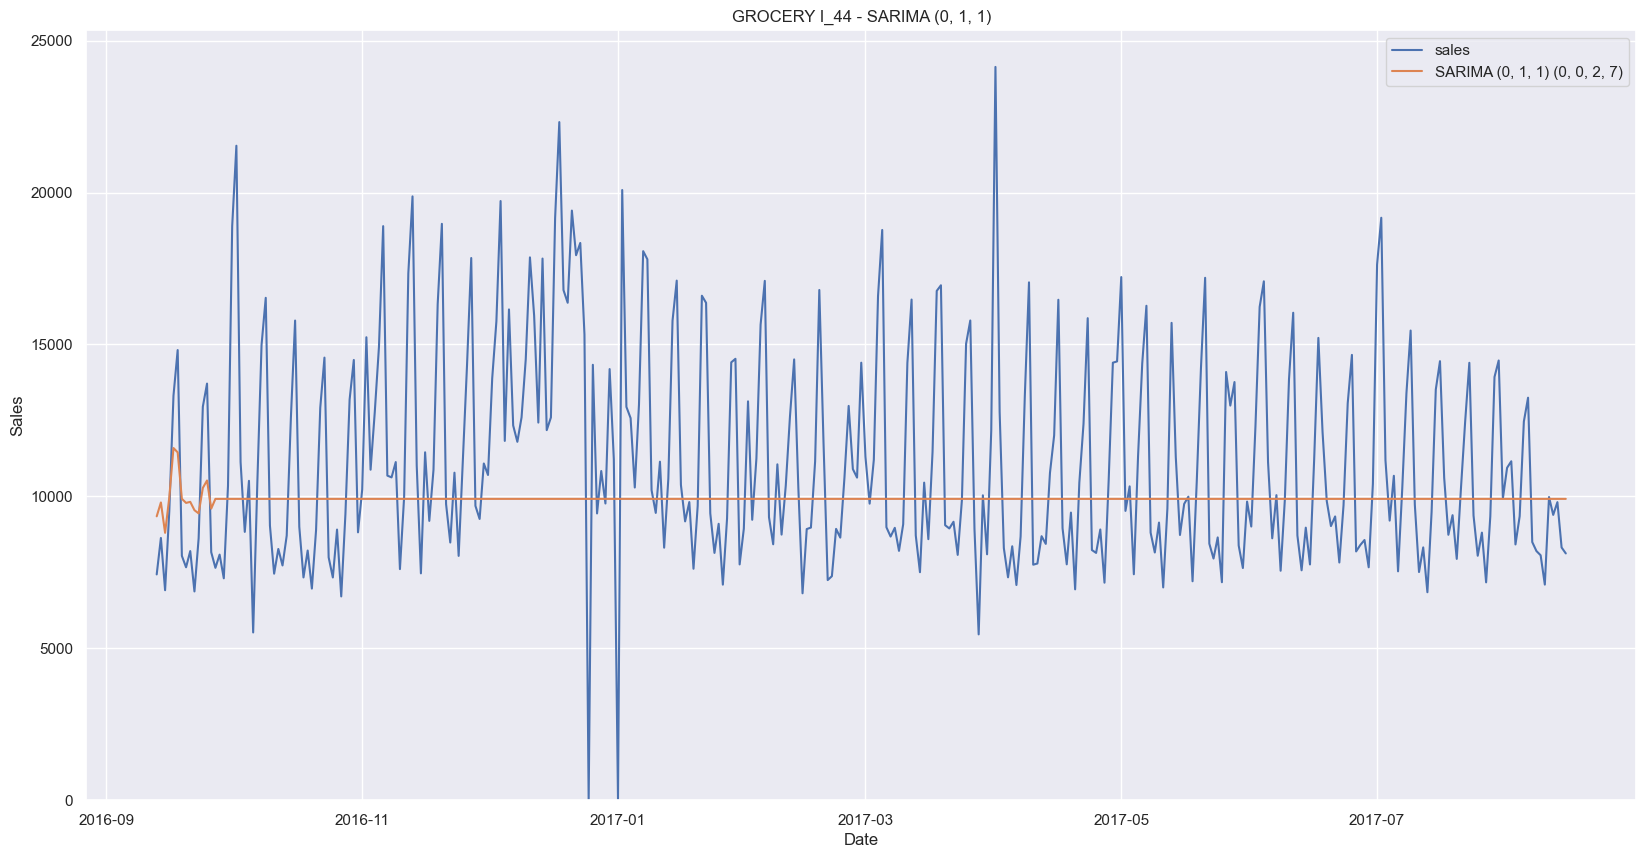

In [22]:
fig,ax = pyplot.subplots(1,1, figsize=(20,10))

ax.plot(tmp_df['date'], tmp_df['sales'], label='sales')
ax.plot(tmp_df['date'], tmp_df[f'SARIMA Preds'], label=f'SARIMA {p,d,q} {seasonal_order_aa[0], seasonal_order_aa[1], seasonal_order_aa[2], seasonal_order_aa[3]}')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
# ax.set_yscale('log')
ax.set_ylim(bottom=0)
ax.set_title(f'GROCERY I_44 - SARIMA {p,d,q}')
ax.legend();

In [29]:
error=rmse(tmp_df[f'SARIMA Preds'], tmp_df['sales'])
error

3799.02953811408

## Manual Reading

In [23]:
# split
train = tmp.iloc[:round(len(tmp) * .8)+1]
test = tmp.iloc[round(len(tmp) * .8)+1:]


In [31]:

# train model
model = SARIMAX(
    train['sales'],
    order=(0,1,1), 
    seasonal_order=(1,0,1,7)
)
results = model.fit()

# predict
start = len(train)
end = len(train) + len(test) - 1
preds = results.predict(start, end, type='levels').rename(f'SARIMA Preds') # type='levels' showing original data (as opposed to the differenced TS)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.54448D+00    |proj g|=  1.68419D-01

At iterate    5    f=  9.44959D+00    |proj g|=  2.94198D-02


 This problem is unconstrained.



At iterate   10    f=  9.42187D+00    |proj g|=  8.96311D-03

At iterate   15    f=  9.41462D+00    |proj g|=  4.77613D-03

At iterate   20    f=  9.41272D+00    |proj g|=  1.32627D-04

At iterate   25    f=  9.39127D+00    |proj g|=  1.20010D-03

At iterate   30    f=  9.38156D+00    |proj g|=  3.71687D-04

At iterate   35    f=  9.37587D+00    |proj g|=  1.29618D-03

At iterate   40    f=  9.33091D+00    |proj g|=  6.80554D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   45    f=  9.33048D+00    |proj g|=  5.91321D-05

At iterate   50    f=  9.33045D+00    |proj g|=  1.17798D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50    100      2     0     0   1.178D-04   9.330D+00
  F =   9.3304512781441318     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


In [32]:


p_df = pd.DataFrame()

# concat result df
test2 = test.reset_index()
# test2['id'] = test2['family'].astype(str) + '_' + test2['store_nbr'].astype(str)

tmp_df = pd.DataFrame()
tmp_df = pd.concat(
    [
        preds.reset_index(drop=True),
        # pred_SARIMAX.predicted_mean.reset_index(drop=True),
        test2[features_to_use]

    ], 
    axis=1
)

# p_df = pd.concat([tmp_df, p_df],axis=1)


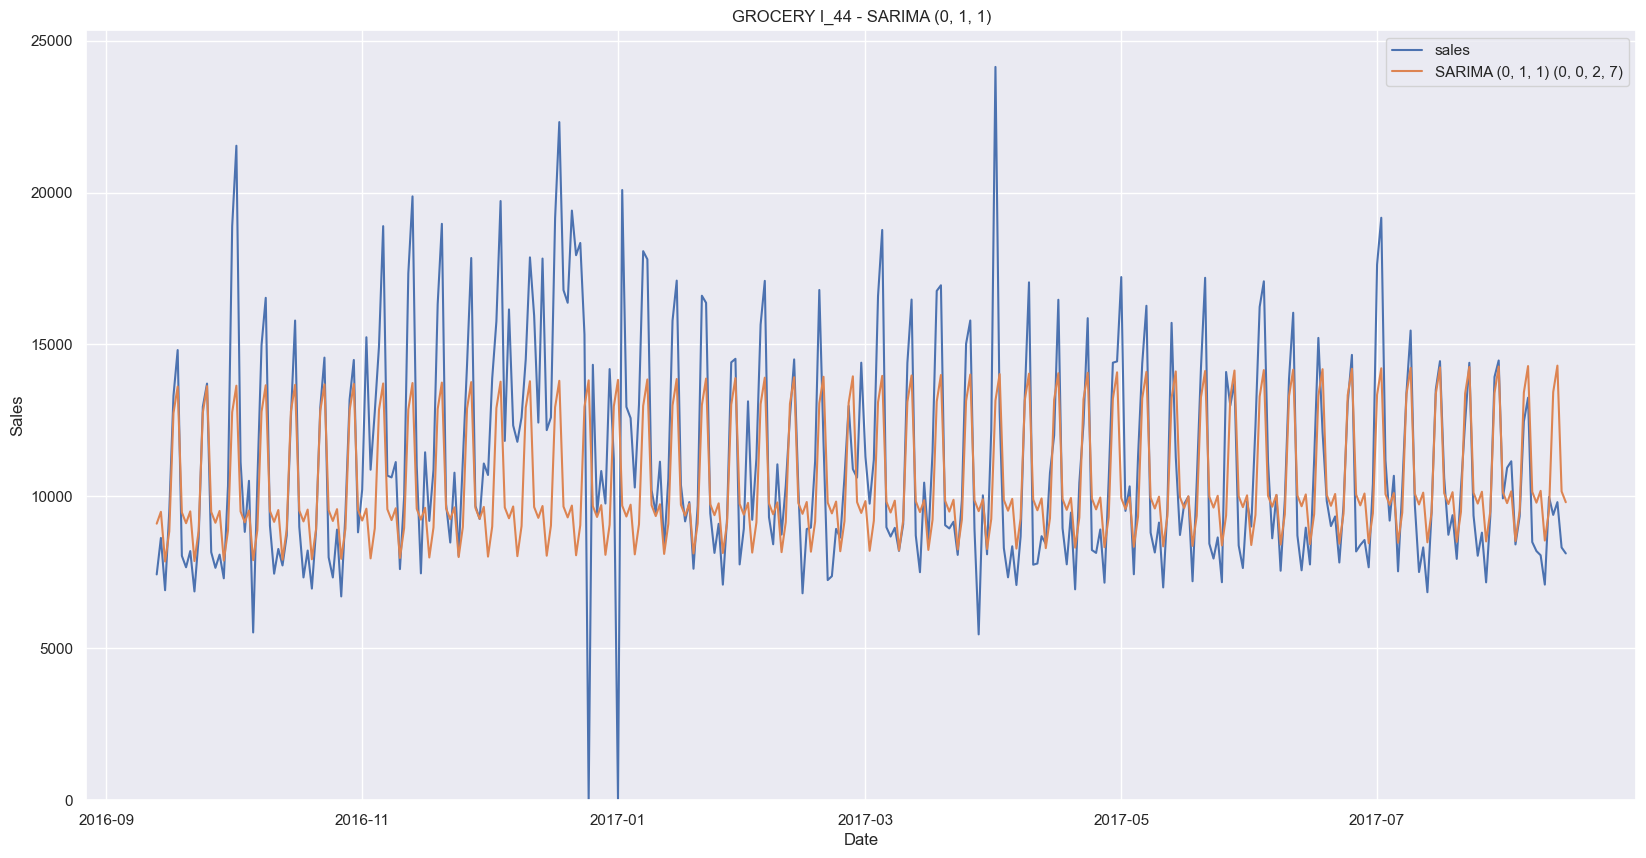

In [33]:
fig,ax = pyplot.subplots(1,1, figsize=(20,10))

ax.plot(tmp_df['date'], tmp_df['sales'], label='sales')
ax.plot(tmp_df['date'], tmp_df[f'SARIMA Preds'], label=f'SARIMA {p,d,q} {seasonal_order_aa[0], seasonal_order_aa[1], seasonal_order_aa[2], seasonal_order_aa[3]}')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
# ax.set_yscale('log')
ax.set_ylim(bottom=0)
ax.set_title(f'GROCERY I_44 - SARIMA {p,d,q}')
ax.legend();

In [34]:
error=rmse(tmp_df[f'SARIMA Preds'], tmp_df['sales'])
error

2808.2544160007437

# SARIMAX

## Re-subset Data

since we'll be using a lot of the exogenous columns now

In [102]:
national_dummy_df = pd.get_dummies(train_engineered['national_holidays'])
natioanl_dummy_lst = national_dummy_df.columns.tolist()   # save for later

regional_dummy_df = pd.get_dummies(train_engineered['regional_local_holidays'])
regional_dummy_lst = regional_dummy_df.columns.tolist()   # save for later

# put national & regional/local together
# description_dummy_df = pd.concat([national_dummy_df, regional_dummy_df], axis=1)
description_dummy_lst = natioanl_dummy_lst.copy()
description_dummy_lst.extend(regional_dummy_lst)

features_to_use = [
    'date','sales', 'out_of_region',
    'onpromotion','oil_price', 
    'is_year_start','is_year_end', 
    'is_wknd','wageday'
]
features_to_use.extend(description_dummy_lst)


exog_vars = [item for item in features_to_use if item not in ['date','sales']]


In [110]:
df = train_engineered[train_engineered['uid']=='GROCERY I_44']

df = df[features_to_use]
df = df.set_index('date')

df = df.asfreq('D')
df[['oil_price']]= df[['oil_price']].interpolate(method='linear')

df = df.fillna(0)



# train test split
train = df.iloc[:round(len(df) * .8)+1]
test = df.iloc[round(len(df) * .8)+1:]

## Best Model (Manual Reading)

In [111]:

# train model
model = SARIMAX(
    train['sales'],
    exog=train[exog_vars],
    # order=(order_aa[0], order_aa[1], order_aa[2]), 
    order=(0,1,1),  #p,d,q
    # seasonal_order =(seasonal_order_aa[0], seasonal_order_aa[1], seasonal_order_aa[2], seasonal_order_aa[3])
    seasonal_order=(1,0,1,7)
)
results = model.fit()
# results.summary()



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          106     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.40912D+00    |proj g|=  1.27278D-01


 This problem is unconstrained.



At iterate    5    f=  9.36058D+00    |proj g|=  4.56147D-02

At iterate   10    f=  9.32232D+00    |proj g|=  1.05675D-02

At iterate   15    f=  9.31433D+00    |proj g|=  1.38778D-03

At iterate   20    f=  9.31340D+00    |proj g|=  4.08802D-04

At iterate   25    f=  9.30674D+00    |proj g|=  4.04021D-03

At iterate   30    f=  9.29318D+00    |proj g|=  1.19598D-03

At iterate   35    f=  9.28318D+00    |proj g|=  1.52139D-03

At iterate   40    f=  9.28250D+00    |proj g|=  6.71161D-05

At iterate   45    f=  9.28091D+00    |proj g|=  1.57569D-03

At iterate   50    f=  9.26975D+00    |proj g|=  1.64427D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [119]:
# predict
start = len(train)
end = len(train) + len(test) - 1
preds = results.predict(
    start, end, 
    exog=test[exog_vars], 
    type='levels'
).rename(f'SARIMAX Preds') # type='levels' showing original data (as opposed to the differenced TS)
# pred_SARIMAX = results.get_forecast(steps=len(test), exog=test[['onpromotion', 'oil_price']])


p_df = pd.DataFrame()

# concat result df
test2 = test.reset_index()

tmp_df = pd.DataFrame()
tmp_df = pd.concat(
    [
        preds.reset_index(drop=True),
        test2[features_to_use]

    ], 
    axis=1
)

p_df = pd.concat([tmp_df, p_df],axis=1)

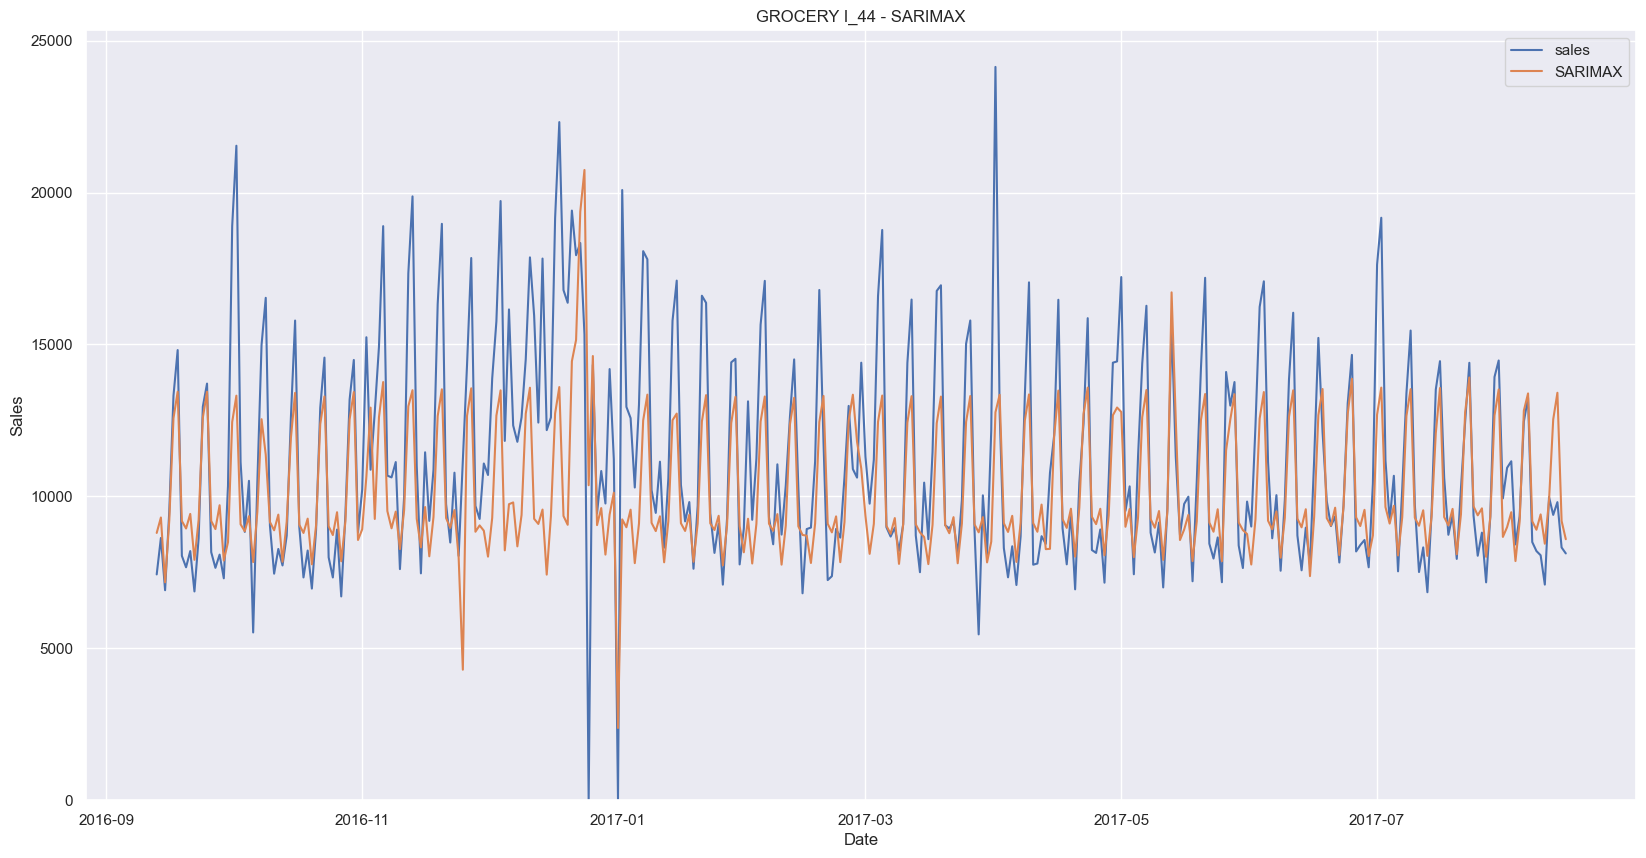

In [128]:
fig,ax = pyplot.subplots(1,1, figsize=(20,10))

ax.plot(p_df['date'], p_df['sales'], label='sales')
ax.plot(p_df['date'], p_df[f'SARIMAX Preds'], label=f'SARIMAX')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
# ax.set_yscale('log')
ax.set_ylim(bottom=0)
ax.set_title(f'GROCERY I_44 - SARIMAX')
ax.legend();

In [124]:
error=rmse(p_df['SARIMAX Preds'], p_df['sales'])
error

2579.0124001533604